# Imports and Utils

In [31]:
# imports and constants
import json
import pickle
import datetime as dt

import gmaps
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import multiprocessing
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns

from IPython.display import display, HTML
import ipywidgets as widgets

# user imports
from utils.process_data import *
from utils.stats import *
from utils.lifesense_utils import *

%matplotlib inline

In [32]:
# Code hider, source: http://chris-said.io/2016/02/13/how-to-make-polished-jupyter-presentations-with-optional-code-visibility/
from IPython.display import HTML

HTML('''
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
''')

# Load Data

In [2]:
state_df = pd.read_pickle("ls_data/state_0_10.df")
phq_df = pd.read_pickle("ls_data/phq_0_16.df")

# Depression group definitions

## Participant categories

- Severe symptoms (PHQ-9 ≥ 15)
- Moderate symptoms (PHQ-9 = 10-14)*
- Mild symptoms (PHQ-9 = 5-9)
- No symptoms (PHQ-9 < 5). 

We estimate that 30-50% of the PHQ-9 ≥ 15 group will show substantial drops of >5 points on the PHQ-9 during the study. Participants in the PHQ-9 = 5-14 range will show the maximum amount of movement in PHQ-9 scores over 4 months. We expect no substantive movement in depression among control participants with a PHQ-9 < 5. This

## Categorical definition of improvement: 

Standard clinical threshold is 5 point on PHQ-9 for full response, however, changes of 2 and 3 are often recommend for decision making. May not be important to categorize at first, given it’s not clear.

## Transition from depressed to non depressed.

Transition from depressed to non-depressed state will use the criterion for reliable and clinically significant change validated for the PHQ-9. Depressed participants (PHQ-9 ≥ 10) who subsequently show PHQ-9<10 and a reduction of ≥ 5 will be classified as transitioning from depressed to non-depressed. Similarly, non-depressed participants (PHQ-9 < 10) that subsequently have PHQ-9 ≥ 10 and an increase of ≥ 5 will be classified as having transitioned from nondepressed to depressed. 

In [3]:
group_df = phq_df[phq_df['redcap_event_name'] == 'week_0_arm_1']

def categorize_phq(x):
    if x < 5: return "no_symp"
    if x <= 9: return "mild"
    if x <= 14: return "moderate"
    if x > 14: return "severe"
    return "N/A"

group_df['baseline_group'] = group_df['phq_total_sc'].apply(categorize_phq)

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [4]:
group_df['baseline_group'].value_counts()

moderate    93
severe      85
no_symp     56
mild        48
Name: baseline_group, dtype: int64

In [5]:
group_df['phq_total_sc'].describe()

count    282.000000
mean      10.932624
std        6.108078
min        0.000000
25%        6.000000
50%       11.000000
75%       15.000000
max       24.000000
Name: phq_total_sc, dtype: float64

In [6]:
phq_group_dict = {k:v for k, v in zip(group_df['pid'].values, group_df['baseline_group'].values)}

phq_df['baseline_group'] = phq_df['pid'].map(phq_group_dict)

In [8]:
event_dict = {
   "week_0_arm_1": 0,
   "week_1_arm_1": 1,
   "week_4_arm_1": 4,
   "week_7_arm_1": 7,
   "week_10_arm_1": 10,
   "week_13_arm_1": 13,
   "week_16_arm_1": 16
}

phq_df['study_wk'] = phq_df['redcap_event_name'].map(event_dict)

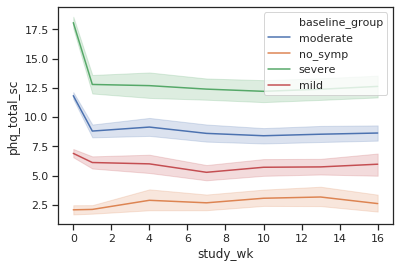

In [9]:
phq_df['phq_start'] = pd.to_datetime(phq_df['phq_start'])
sns.lineplot(x="study_wk", y="phq_total_sc", hue="baseline_group", data=phq_df)

In [10]:
phq_df['timestamp'] = (phq_df['phq_start'] - dt.datetime(1970,1,1)).dt.total_seconds()

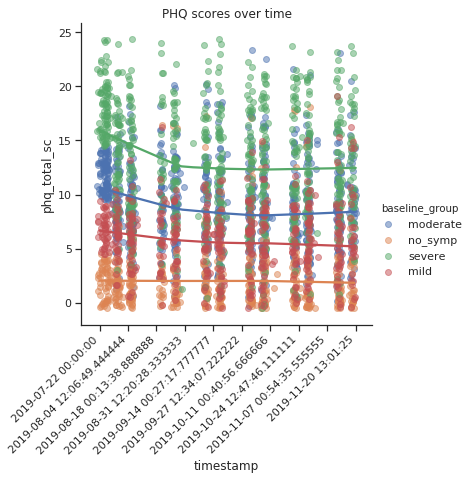

In [11]:
import matplotlib.dates as md


sns.lmplot(x='timestamp', y='phq_total_sc', 
           data=phq_df, 
           lowess=True, 
           hue="baseline_group", 
           x_jitter=100000, y_jitter=0.5,
           scatter_kws = {
               'alpha': 0.5
           },
          )
ax=plt.gca()
ticks = np.linspace(phq_df['timestamp'].min(), phq_df['timestamp'].max(), 10)
idx = pd.date_range(phq_df['phq_start'].min(), phq_df['phq_start'].max(), 10).to_pydatetime()
plt.xticks(ticks, idx, rotation=45, ha='right')
#xfmt = md.DateFormatter('%Y-%m-%d')
#ax.xaxis.set_major_formatter(xfmt)
plt.title("PHQ scores over time")
plt.show()

In [12]:
phq_df[(phq_df['baseline_group'] == 'severe') & (phq_df['study_wk'] < 2)][['pid', 'phq_total_sc', 'phq_start']].head(20)

,pid,phq_total_sc,phq_start
121,01495950,15,2019-07-25 00:00:00
0,01495950,8,2019-07-30 07:57:47
0,01495950,5,2019-08-05 21:18:28
165,03384972,18,2019-07-25 00:00:00
0,03384972,15,2019-08-05 20:07:10
57,04133537,15,2019-07-23 00:00:00
0,04133537,9,2019-07-30 10:29:34
0,04133537,9,2019-08-05 16:01:48
54,05261598,18,2019-07-23 00:00:00
0,05261598,10,2019-07-30 14:56:41


In [15]:
print("Standard deviations")
phq_df.groupby('baseline_group')['phq_total_sc'].std().sort_values()

Standard deviations


baseline_group
mild        3.083363
no_symp     3.247513
moderate    3.936089
severe      5.204522
Name: phq_total_sc, dtype: float64

## Build Sequence DF

In [41]:
phq_df[phq_df['redcap_event_name'] == 'week_1_arm_1']['phq_start'].min()

Timestamp('2019-07-27 06:43:24')

In [13]:
survey_dates = [
    '2019-07-23',
    '2019-07-30',
    '2019-08-05', 
    '2019-08-20',
    '2019-08-26',
    '2019-09-10',
    '2019-09-16',
    '2019-10-01',
    '2019-10-07'
]

In [50]:
survey_idxs = []
phq_tots = []
phq_dates = []
baseline_groups = []
pids = []

for pid, group in phq_df.groupby('pid', as_index=False):

    
    for idx, date in enumerate(survey_dates):
        tot = np.nan
        phq_date = np.nan        
        sel_row = group[(group['phq_start'] > (pd.to_datetime(date) - pd.Timedelta(3, unit='D'))) & 
                        (group['phq_start'] < (pd.to_datetime(date) + pd.Timedelta(5, unit='D')))]
        #print(date)
        #display(sel_row)
        if sel_row.shape[0] > 0:
            tot = sel_row['phq_total_sc'].values[0]
            phq_date = sel_row['phq_start'].values[0]
            
        phq_tots.append(tot)
        phq_dates.append(phq_date)
        baseline_groups.append(group['baseline_group'].values[0])
        pids.append(pid)
        survey_idxs.append(idx)

In [51]:
phq_seq_df = pd.DataFrame()
phq_seq_df['pid'] = pids
phq_seq_df['baseline_group'] = baseline_groups
phq_seq_df['survey_idx'] = survey_idxs
phq_seq_df['date'] = phq_dates
phq_seq_df['phq_tot'] = phq_tots

In [105]:
color_map = {
    'no_symp': 'green',
    'mild': 'blue',
    'moderate': 'orange',
    'severe': 'red'
}

In [130]:
phq_pivot = phq_seq_df.pivot_table(index="pid", columns=['survey_idx'])

# need better imputation
phq_pivot = phq_pivot.T.fillna(phq_pivot.mean(axis=1)).T

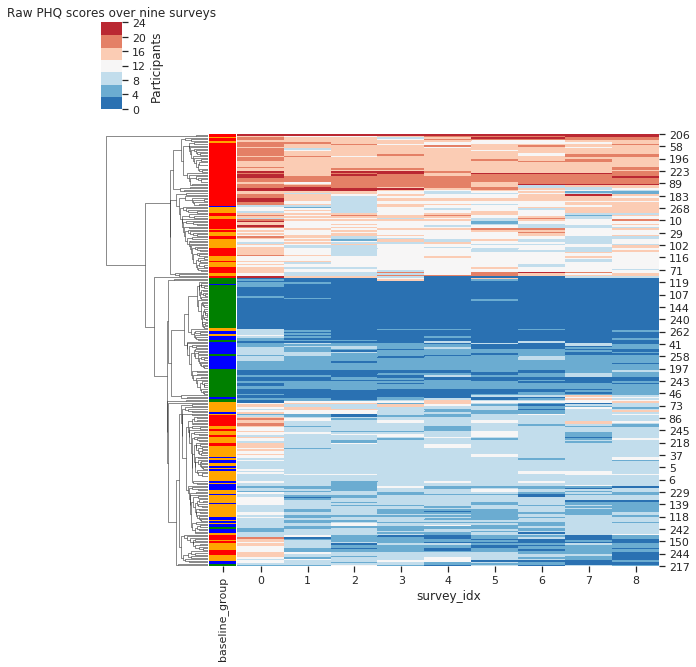

In [135]:
phq_pivot_cluster = phq_pivot.copy()
phq_pivot_cluster = phq_pivot_cluster.reset_index()
phq_pivot_cluster['baseline_group'] = phq_pivot_cluster['pid'].map(phq_group_dict)
phq_pivot_cluster = phq_pivot_cluster.drop('pid', axis='columns')

group = phq_pivot_cluster.pop("baseline_group")
row_colors = group.map(color_map)
cmap = sns.color_palette("RdBu_r", 7)

sns.clustermap(phq_pivot_cluster['phq_tot'], cmap=cmap, figsize=(10,10), 
               col_cluster=False, row_colors=row_colors)
plt.ylabel("Participants")
plt.title("Raw PHQ scores over nine surveys")
plt.show()

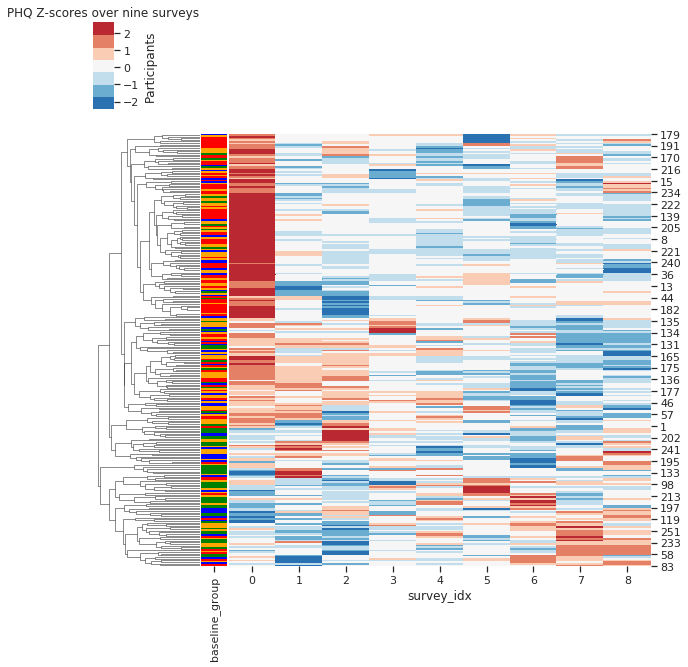

In [140]:
phq_pivot_z = phq_pivot.T
phq_pivot_z = ((phq_pivot_z - phq_pivot_z.mean())/phq_pivot_z.std()).T
phq_pivot_z = phq_pivot_z.dropna()

phq_pivot_z = phq_pivot_z.reset_index()
phq_pivot_z['baseline_group'] = phq_pivot_z['pid'].map(phq_group_dict)
phq_pivot_z = phq_pivot_z.drop('pid', axis='columns')

group = phq_pivot_z.pop("baseline_group")
row_colors = group.map(color_map)
cmap = sns.color_palette("RdBu_r", 7)

sns.clustermap(phq_pivot_z['phq_tot'], cmap=cmap, figsize=(10,10), 
               col_cluster=False, row_colors=row_colors)
plt.ylabel("Participants")
plt.title("PHQ Z-scores over nine surveys")
plt.show()